In [1]:
import openpyxl as pyxl
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import string
import copy

In [2]:
ODwb = pyxl.load_workbook("15Feb2017 ME007 PJK14spec mCherryMutH OD.xlsx")
REDwb = pyxl.load_workbook("15Feb2017 ME007 PJK14spec mCherryMutH mCherry fluorescence.xlsx")
GREENwb = pyxl.load_workbook("15Feb2017 ME007 PJK14spec mCherryMutH GFP fluorescence.xlsx")

In [3]:
ODsheet = ODwb[ODwb.get_sheet_names()[0]]
REDsheet = REDwb[REDwb.get_sheet_names()[0]]
GREENsheet = GREENwb[GREENwb.get_sheet_names()[0]]

In [4]:
samples = {}
aTc_conc = np.array([0, 10, 20, 40, 60, 100])
for letter in ['A', 'B', 'C', 'D']:
    for i in [1,2,3,4,5,6]:
        well = letter + str(i)
        samples[well]={'aTc': aTc_conc[i-1], 'OD': np.zeros(60), 'Red': np.zeros(60), 'Green': np.zeros(60)}

In [5]:
xl_data_columns = list(string.ascii_uppercase[2:27])

In [6]:
def transfer_data(sheet, columns, dictionary, meas):
    for col in columns:
        letter = sheet[col+str(1)].value
        number = sheet[col+str(2)].value
        ref = letter + str(number)
        index = 0
        for i in range(4,64):
            dictionary[ref][meas][index]=sheet[col+str(i)].value
            index = index+1
    return

In [7]:
transfer_data(ODsheet,xl_data_columns, samples, 'OD')
transfer_data(REDsheet, xl_data_columns, samples, 'Red')
transfer_data(GREENsheet, xl_data_columns, samples, 'Green')

In [8]:
samples_bgsub = copy.deepcopy(samples)

In [9]:
for key, item in samples_bgsub.items():
    item['OD'] = item['OD'] - .99*np.min(item['OD'])
    item['Red'] = item['Red'] - .99*np.min(item['Red'])
    item['Green'] = item['Green'] - .99*np.min(item['Green'])

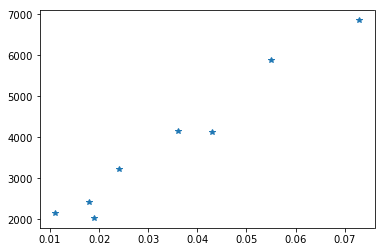

In [10]:
plt.plot(samples_bgsub['A2']['OD'][40:48],samples_bgsub['A4']['Red'][40:48],'*')

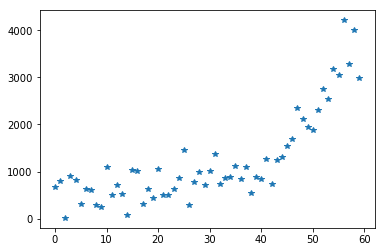

In [11]:
plt.plot(samples_bgsub['A2']['Red'],'*')

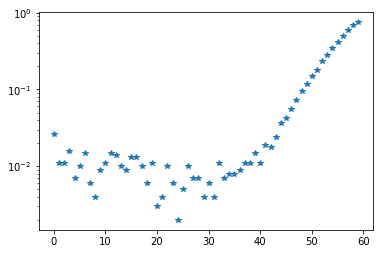

In [12]:
plt.semilogy(samples_bgsub['A2']['OD'],'*')

In [13]:
samples_expphase = copy.deepcopy(samples_bgsub)

In [14]:
for key, item in samples_expphase.items():
    item['OD'] = item['OD'][40:50]
    item['Red'] = item['Red'][40:50]
    item['Green'] = item['Green'][40:50]

In [15]:
def slopefind(x,y):
    A = np.vstack([x,np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A,y)[0]
    return m, c

In [16]:
red_per_cell = np.zeros((4,6))
for letter in 'ABCD':
    for i in range(1,7):
        row = string.ascii_uppercase.index(letter)
        column = i - 1
        well = letter + str(i)
        red_per_cell[row,column] = slopefind(samples_expphase[well]['OD'],samples_expphase[well]['Red'])[0]


In [17]:
np.set_printoptions(precision=0)
red_per_cell

array([[   556.,  12584.,  24120.,  57334.,  63174.,  82145.],
       [ -2886.,   7536.,  17109.,  48840.,  68824.,  78430.],
       [ -3407.,  11701.,  27027.,  51461.,  59867.,  79022.],
       [ -7724.,   9558.,  22679.,  48056.,  69600.,  79163.]])

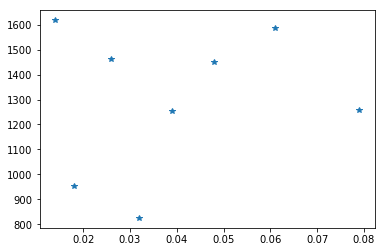

In [18]:
plt.plot(samples_bgsub['D2']['OD'][40:48],samples_bgsub['D2']['Red'][40:48],'*')

In [19]:
mean_mutH = np.mean(red_per_cell,0)
std_mutH = np.std(red_per_cell,0)
print('Mean mutH expression is ', mean_mutH, '.')
print('The standard deviation of mutH expression is ', std_mutH, '.')

Mean mutH expression is  [ -3365.  10345.  22734.  51423.  65366.  79690.] .
The standard deviation of mutH expression is  [ 2941.  1960.  3605.  3638.  4029.  1444.] .


In [20]:
m, c = slopefind(aTc_conc, mean_mutH)
print(m)
print(c)

847.74552706
5201.78074478


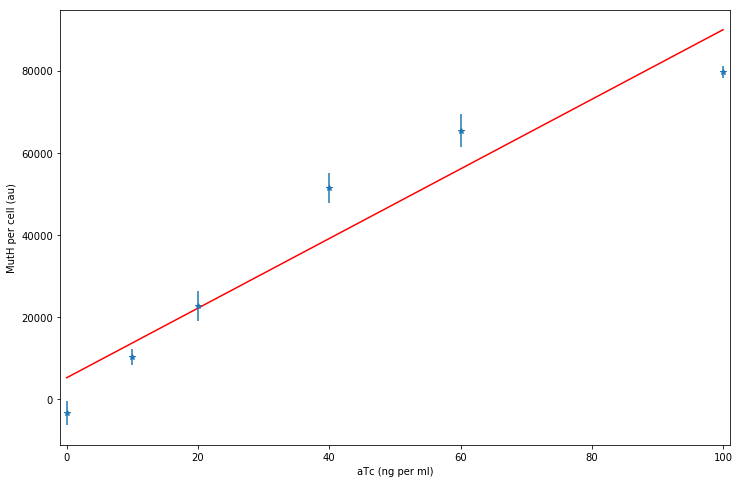

In [21]:
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(111)
axes.errorbar(aTc_conc,mean_mutH,yerr=std_mutH, fmt='*')
axes.set_xlim([-1,101])
axes.plot(aTc_conc, m*aTc_conc+c, 'r-')
axes.set_xlabel('aTc (ng per ml)')
axes.set_ylabel('MutH per cell (au)')

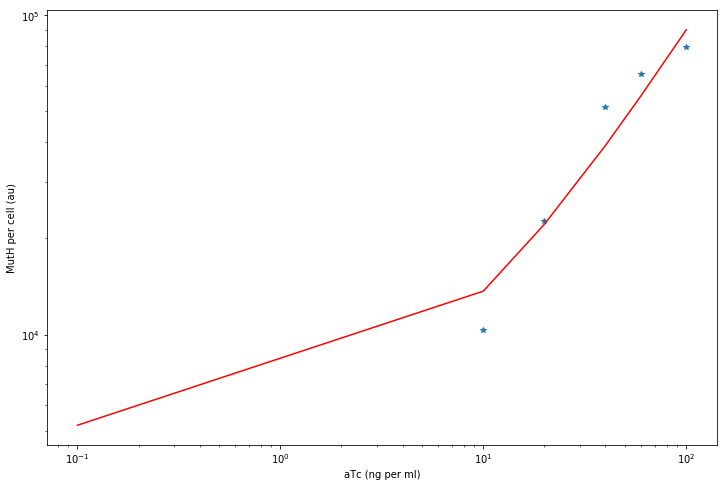

In [22]:
fig2 = plt.figure(figsize=(12,8))
axes2 = fig2.add_subplot(111)
axes2.loglog([.1,10,20,40,60,100],mean_mutH,'*')
axes2.loglog([.1,10,20,40,60,100], m*aTc_conc+c,'r-')
axes2.set_xlabel('aTc (ng per ml)')
axes2.set_ylabel('MutH per cell (au)')

In [23]:
fig.savefig('MutH per cell vs aTc.png')

In [24]:
fig2.savefig('MutH per cell vs aTc on a log scale.png')

In [25]:
t = np.array(list(range(0,1200,20)))

In [26]:
growth_rate = np.zeros((4,6))
for letter in 'ABCD':
    for i in range(1,7):
        row = string.ascii_uppercase.index(letter)
        column = i - 1
        well = letter + str(i)
        growth_rate[row,column] = slopefind(t[40:50],np.log(samples_expphase[well]['OD']))[0]


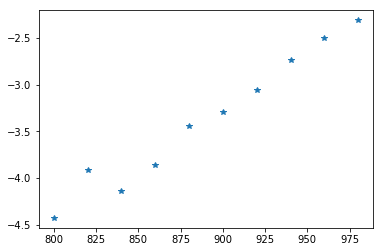

In [27]:
plt.plot(t[40:50],np.log(samples_expphase['A1']['OD']),'*')

In [28]:
np.set_printoptions(precision=4)
growth_rate

array([[ 0.0117,  0.0128,  0.0127,  0.0126,  0.0115,  0.0114],
       [ 0.0133,  0.0118,  0.0115,  0.0104,  0.0119,  0.0117],
       [ 0.0109,  0.0104,  0.0124,  0.0126,  0.0118,  0.015 ],
       [ 0.0099,  0.0119,  0.0132,  0.0124,  0.0115,  0.0139]])

In [29]:
print('The doubling time of these cells in M63 glucose is', np.log(2)/.012, 'minutes.')

The doubling time of these cells in M63 glucose is 57.7622650467 minutes.


In [30]:
green_per_cell = np.zeros((4,6))
for letter in 'ABCD':
    for i in range(1,7):
        row = string.ascii_uppercase.index(letter)
        column = i - 1
        well = letter + str(i)
        green_per_cell[row,column] = slopefind(samples_expphase[well]['OD'],samples_expphase[well]['Green'])[0]

In [31]:
np.set_printoptions(precision=0)
green_per_cell

array([[ 20389.,  20458.,  23416.,  20338.,  20493.,  21844.],
       [ 19006.,  14689.,  16424.,  16678.,  18940.,  19785.],
       [ 17546.,  16508.,  18818.,  17777.,  20110.,  20343.],
       [ 17060.,  17209.,  19052.,  19571.,  22008.,  21286.]])

In [32]:
np.mean(green_per_cell,0)

array([ 18500.,  17216.,  19427.,  18591.,  20388.,  20815.])

In [33]:
np.std(green_per_cell,0)

array([ 1305.,  2086.,  2522.,  1444.,  1097.,   801.])